In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Penguin data ~
k-nn - supervised learning 

In [65]:
# ~ part A & B ~ loading & preparing data ~ #

df = pd.read_csv('data\\penguin.csv')

# first 100, 80, 50 from Adélie, Gentoo & Chinstrap penguins
adelie = df[df['species'] == 'Adelie'].head(100)
gentoo = df[df['species'] == 'Gentoo'].head(80)
chinstrap = df[df['species'] == 'Chinstrap'].head(50)
pd.set_option('future.no_silent_downcasting', True)

# train matrix X_train with 2 features - flipper length & culmen length
X_train = pd.concat([adelie[['flipper_length_mm', 'culmen_length_mm']], gentoo[['flipper_length_mm', 'culmen_length_mm']], chinstrap[['flipper_length_mm', 'culmen_length_mm']]],ignore_index=True)

# train labels y_train with 230 labels - 0 for Adélie, 1 for Gentoo, 2 for Chinstrap for each individual in X_train
y_train = pd.concat([adelie['species'].replace({'Adelie': 0}), gentoo['species'].replace({'Gentoo': 1}), chinstrap['species'].replace({'Chinstrap': 2})], ignore_index=True)

# test matrix X_test and labels vector y_test for the rest of the penguins
X_test = df[['flipper_length_mm', 'culmen_length_mm']].iloc[230:].reset_index(drop=True)
y_test = df['species'].replace({'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2}).iloc[230:].reset_index(drop=True)

In [66]:
# ~ part C ~ k-nn algorithm implementation ~ #

def dist_neigh(X_train, X_test):
    """
    compute the Euclidean distance between each pair of points
    use np.sort to sort the distances.
    return the k nearest neighbors for each point in X_test and 
    their distances from the corresponding points in X_train.
    """
    # convert to numpy arrays if needed
    Xtr = np.asarray(X_train) 
    Xte = np.asarray(X_test) 

    diffs = Xtr[:, np.newaxis, :] - Xte[np.newaxis, :, :]
    distances = np.linalg.norm(diffs, axis=2) 
    
    sorted_indices = np.argsort(distances, axis=0) 
    sorted_distances = np.sort(distances, axis=0)
     
    return sorted_indices, sorted_distances



def knn_classifier(X_train, y_train, X_test, y_test, features=None, k=3):
    """
    k-Nearest Neighbors classifier - supervised, 
    using majority vote with tie-breaking
    by minimal sum of distances. 
    return predicted labels for each test point
    and fraction of correct predictions
    """
    Xtr = np.asarray(X_train)  
    Xte = np.asarray(X_test)  
    ytr = np.asarray(y_train)
    yte = np.asarray(y_test)  

    # if a subset of features is specified, slice columns
    if features is not None:
        Xtr = Xtr[:, features] 
        Xte = Xte[:, features]  

    sorted_indices, sorted_distances = dist_neigh(Xtr, Xte)
    n_test = Xte.shape[0]

    # for each test point, pick the top k neighbors and do majority vote
    predictions = np.empty(n_test, dtype=int)

    for j in range(n_test):
        # neighbor indices - k closest - for test point j
        neigh_idxs = sorted_indices[:k, j]
        neigh_labels = ytr[neigh_idxs]         
        neigh_dists = sorted_distances[:k, j] 

        # count occurrences of each label among the k neighbors
        unique_labels, counts = np.unique(neigh_labels, return_counts=True) # by request
        max_count = counts.max()
        tied_labels = unique_labels[counts == max_count]

        if tied_labels.shape[0] > 1:
            # tie-breaking - compute sum of distances for each tied label
            tie_sums = {}
            for lbl in tied_labels:
                tie_mask = (neigh_labels == lbl)
                tie_sums[lbl] = neigh_dists[tie_mask].sum()
                predictions[j] = min(tie_sums, key=tie_sums.get)
        else:
            # pick the unique label with highest count
            predictions[j] = tied_labels[0]

    accuracy = np.mean(predictions == yte)  # accuracy against y_test
    
    return predictions, accuracy

k = 1 → Accuracy = 96.49%
k = 3 → Accuracy = 97.37%
k = 5 → Accuracy = 98.25%


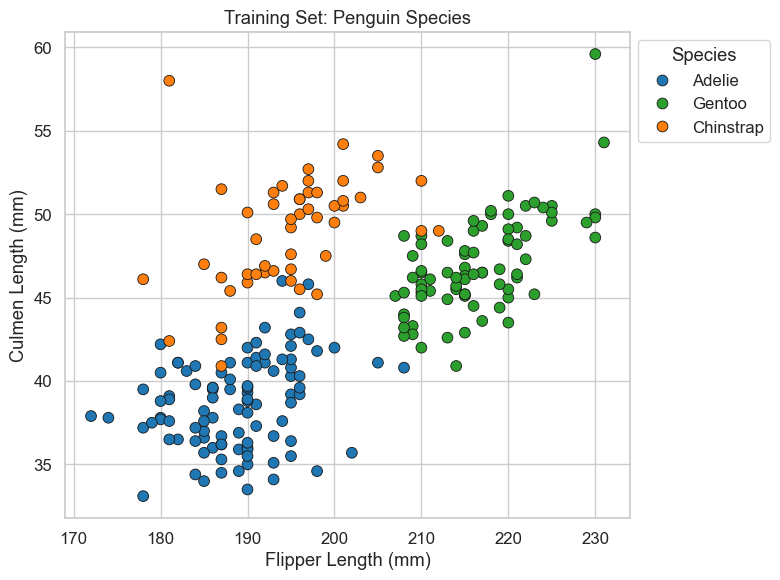

In [67]:
# ~ part D ~ training the model ~ #

for k in [1, 3, 5]:
    # features is 2 - flipper length & culmen length like we define above
    y_pred, accuracy = knn_classifier(X_train, y_train, X_test, y_test, features=None, k=k)
    print(f"k = {k} → Accuracy = {accuracy * 100:.2f}%")

train_df = X_train.copy()
train_df['species'] = y_train.map({0: 'Adelie', 1: 'Gentoo', 2: 'Chinstrap'})
palette_simple = {'Adelie': 'tab:blue', 'Chinstrap': 'tab:orange', 'Gentoo': 'tab:green'}

plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='flipper_length_mm', y='culmen_length_mm', hue='species', palette=palette_simple, s=60, edgecolor='k')
plt.title("Training Set: Penguin Species")
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Culmen Length (mm)')
plt.legend(title='Species', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

k = 1 → Accuracy = 99.12%
k = 3 → Accuracy = 97.37%
k = 5 → Accuracy = 97.37%


<Figure size 1600x1000 with 0 Axes>

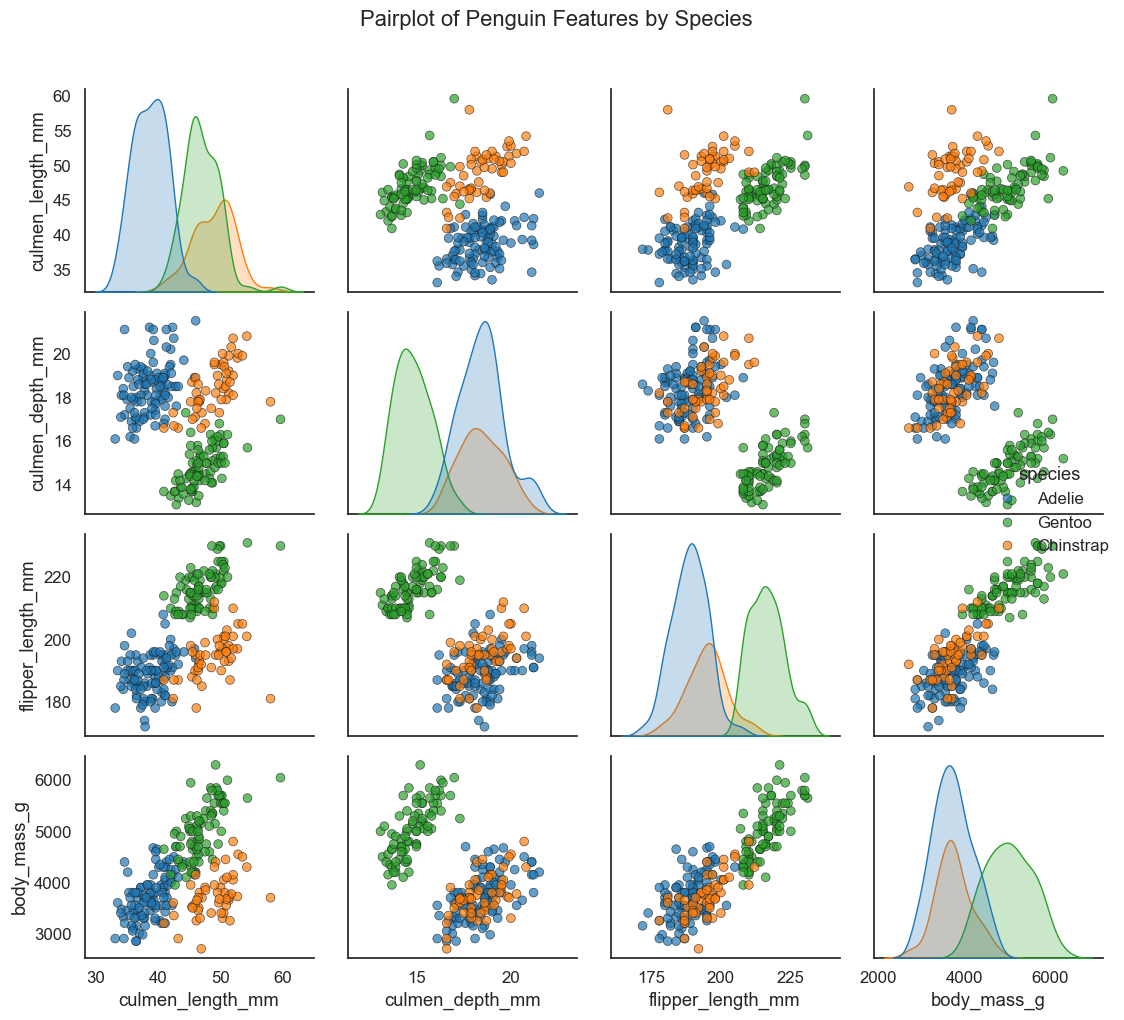

In [ ]:
# ~ part E ~ train on all features ~ #
df_clean = df.dropna(subset=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'])

adelie_all = df_clean[df_clean['species'] == 'Adelie'].head(100)
gentoo_all = df_clean[df_clean['species'] == 'Gentoo'].head(80)
chinstrap_all = df_clean[df_clean['species'] == 'Chinstrap'].head(50)

feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

X_train_all = pd.concat([adelie_all[feature_cols], gentoo_all[feature_cols], chinstrap_all[feature_cols]], ignore_index=True)

y_train_all = pd.concat([ adelie_all['species'].replace({'Adelie': 0}), gentoo_all['species'].replace({'Gentoo': 1}), chinstrap_all['species'].replace({'Chinstrap': 2})], ignore_index=True).infer_objects(copy=False)

X_test_all = df_clean[feature_cols].iloc[230:].reset_index(drop=True)
y_test_all = df_clean['species'].replace({'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2}).iloc[230:].reset_index(drop=True).infer_objects(copy=False)


for k in [1, 3, 5]:
    _, acc_all = knn_classifier(X_train_all, y_train_all, X_test_all, y_test_all, features=None, k=k)
    print(f"k = {k} → Accuracy = {acc_all * 100:.2f}%")


train_plot = X_train_all.copy()
train_plot['species'] = y_train_all.map({0: 'Adelie', 1: 'Gentoo', 2: 'Chinstrap'})

palette = {'Adelie': 'tab:blue', 'Chinstrap': 'tab:orange', 'Gentoo': 'tab:green'}

# scatter plots & KDE like the example
plt.figure(figsize=(16, 10))
sns.pairplot(train_plot, vars=feature_cols, hue='species', palette=palette, diag_kind='kde', plot_kws={'edgecolor': 'k', 's': 40, 'alpha': 0.7})
plt.suptitle("Pairplot of Penguin Features by Species", y=1.02)
plt.tight_layout()
plt.show()